In [2]:
import sys
import os

# Add the src folder to Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Load environment variables from src/.env
from dotenv import load_dotenv
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), 'src', '.env'))

True

In [4]:
import pandas as pd

# Read the combined cases final CSV file
cases_df = pd.read_csv('../data/final_test/combined_cases_final.csv')

In [5]:
cases_df.columns

Index(['case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied',
       'application_of_law_phrases', 'reason', 'if_law_applied_llama',
       'application_of_law_phrases_llama', 'reason_llama',
       'if_law_applied_claude', 'application_of_law_phrases_claude',
       'reason_claude', 'confidence', 'agreement_with', 'final_annotation'],
      dtype='object')

In [5]:
cases_df['case_uri'].values[0]

'https://caselaw.nationalarchives.gov.uk/ewhc/ch/2009/1229'

In [ ]:



#Total number of caselaw
#Their distribution among different categories/courts (ewhc,..)
#Total number of paragraphs 
#Number of agreemed paragraphs (where llama and open-ai-mini agreed)
#Number of disagreement 
#Number of positives by llama
#Number of positives by openAI
#After resolution number of positives --final_annotation


Loaded dataset with shape: (24000, 16)
Columns: ['case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied', 'application_of_law_phrases', 'reason', 'if_law_applied_llama', 'application_of_law_phrases_llama', 'reason_llama', 'if_law_applied_claude', 'application_of_law_phrases_claude', 'reason_claude', 'confidence', 'agreement_with', 'final_annotation']
LEGAL DATASET ANALYSIS REPORT

1. TOTAL NUMBER OF CASE LAWS: 426

2. DISTRIBUTION BY COURT CATEGORIES:
----------------------------------------
  ewhc: 229 cases (53.8%)
  ewca: 138 cases (32.4%)
  ukftt: 16 cases (3.8%)
  ewfc: 8 cases (1.9%)
  ukut: 7 cases (1.6%)
  ewcop: 6 cases (1.4%)
  uksc: 6 cases (1.4%)
  eat: 5 cases (1.2%)
  ukait: 5 cases (1.2%)
  ukpc: 5 cases (1.2%)
  ewcc: 1 cases (0.2%)

3. TOTAL NUMBER OF PARAGRAPHS: 24000

4. AGREEMENT ANALYSIS:
----------------------------------------
  Total paragraphs with valid predictions: 23935
  Agreements (Llama & OpenAI-mini): 19673
  Disagreements: 4262
  Agreement R

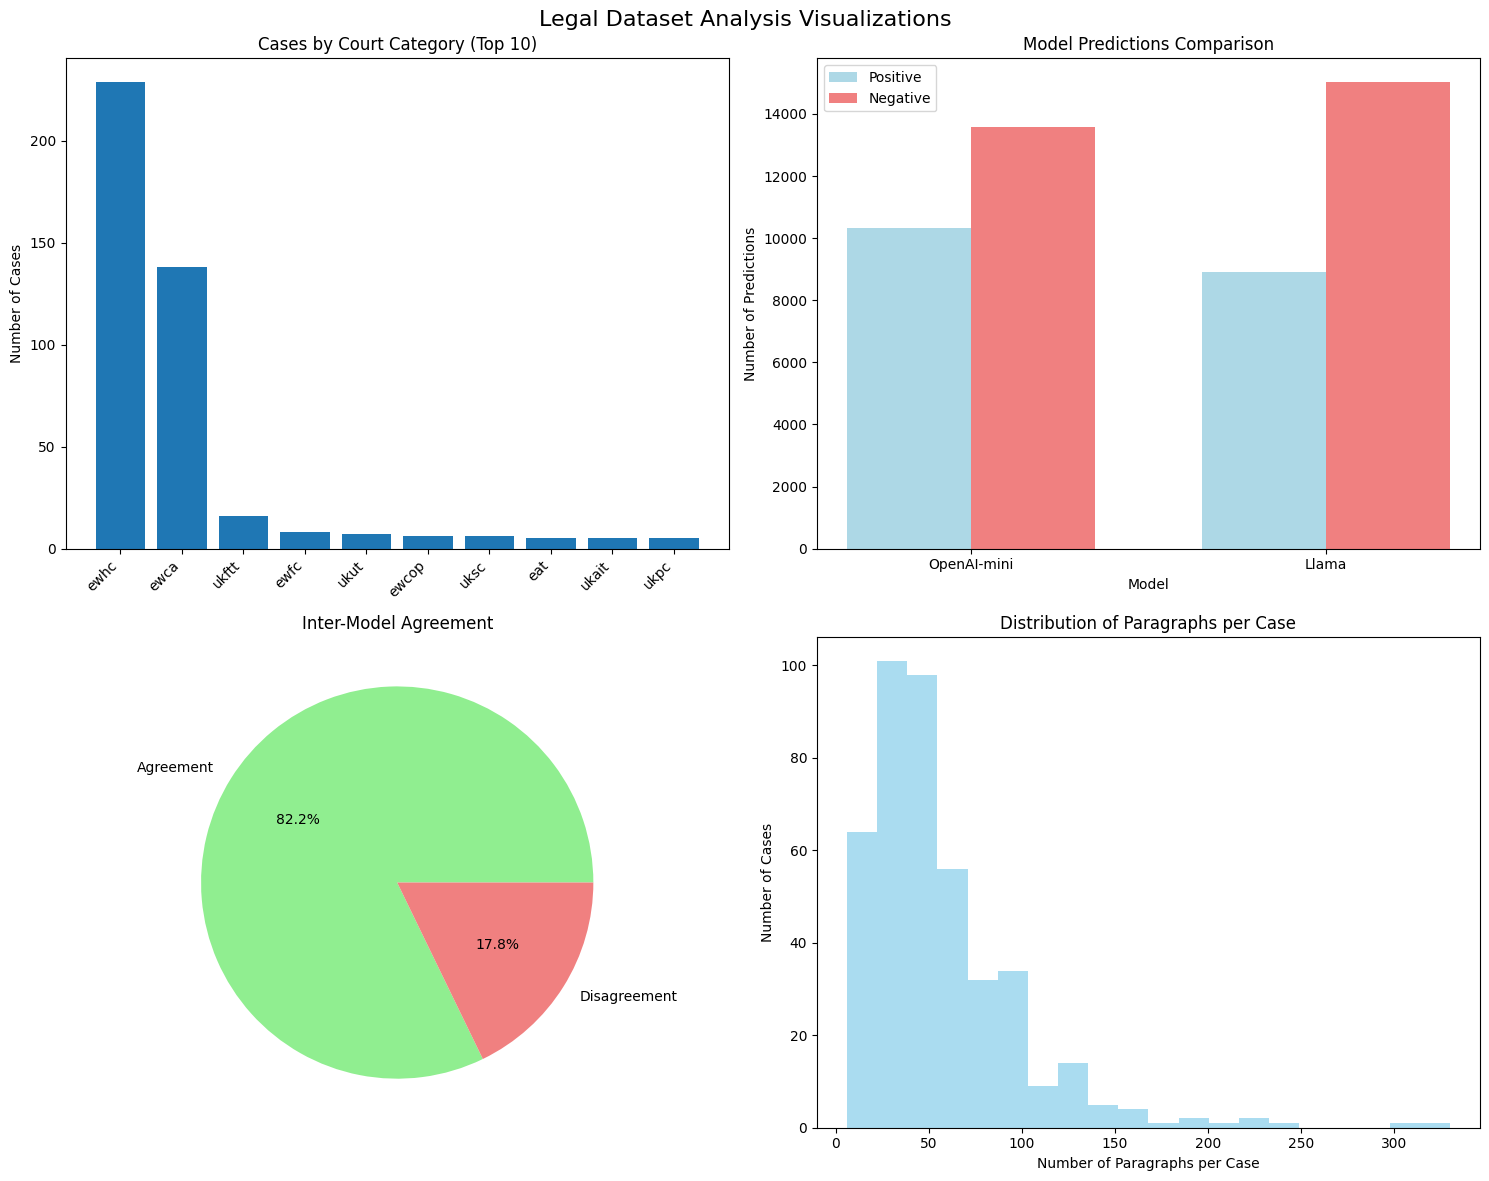

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

def analyze_legal_dataset(df):
    """
    Comprehensive analysis of legal dataset with case law and paragraph statistics
    """
    
    print("=" * 60)
    print("LEGAL DATASET ANALYSIS REPORT")
    print("=" * 60)
    
    # 1. Total number of case laws
    unique_cases = df['case_uri'].nunique()
    print(f"\n1. TOTAL NUMBER OF CASE LAWS: {unique_cases}")
    
    # 2. Distribution among different categories/courts
    print(f"\n2. DISTRIBUTION BY COURT CATEGORIES:")
    print("-" * 40)
    
    # Extract court categories from case_uri (assuming format like _ewhc_admin_2025_462)
    def extract_court_category(case_uri):
        if pd.isna(case_uri):
            return 'Unknown'
        
        try:
            # Extract from URL format: https://caselaw.nationalarchives.gov.uk/ewhc/ch/2009/1229
            # Split by '/' and get only the main court part
            parts = case_uri.split('/')
            if len(parts) >= 4:
                return parts[3]  # Just 'ewhc', 'ukftt', etc.
            else:
                return 'Unknown'
        except:
            return 'Unknown'
    
    df['court_category'] = df['case_uri'].apply(extract_court_category)
    court_distribution = df['case_uri'].groupby(df['court_category']).nunique().sort_values(ascending=False)
    
    for court, count in court_distribution.items():
        percentage = (count / unique_cases) * 100
        print(f"  {court}: {count} cases ({percentage:.1f}%)")
    
    # 3. Total number of paragraphs
    total_paragraphs = len(df)
    print(f"\n3. TOTAL NUMBER OF PARAGRAPHS: {total_paragraphs}")
    
    # 4. Agreement Analysis
    print(f"\n4. AGREEMENT ANALYSIS:")
    print("-" * 40)
    
    # Convert boolean/string values to consistent format
    def normalize_boolean(val):
        if pd.isna(val):
            return None
        if isinstance(val, bool):
            return val
        if isinstance(val, str):
            return val.lower() in ['true', '1', 'yes']
        if isinstance(val, (int, float)):
            return bool(val)
        return None
    
    df['if_law_applied_norm'] = df['if_law_applied'].apply(normalize_boolean)
    df['if_law_applied_llama_norm'] = df['if_law_applied_llama'].apply(normalize_boolean)
    
    # Remove rows where either model's prediction is missing
    valid_predictions = df.dropna(subset=['if_law_applied_norm', 'if_law_applied_llama_norm'])
    
    # Calculate agreements and disagreements
    agreements = (valid_predictions['if_law_applied_norm'] == valid_predictions['if_law_applied_llama_norm']).sum()
    disagreements = len(valid_predictions) - agreements
    
    print(f"  Total paragraphs with valid predictions: {len(valid_predictions)}")
    print(f"  Agreements (Llama & OpenAI-mini): {agreements}")
    print(f"  Disagreements: {disagreements}")
    
    if len(valid_predictions) > 0:
        agreement_rate = (agreements / len(valid_predictions)) * 100
        print(f"  Agreement Rate: {agreement_rate:.1f}%")
    
    # 5. Positive predictions by each model
    print(f"\n5. POSITIVE PREDICTIONS BY MODEL:")
    print("-" * 40)
    
    # OpenAI positives
    openai_positives = df['if_law_applied_norm'].sum() if df['if_law_applied_norm'].notna().any() else 0
    openai_total = df['if_law_applied_norm'].notna().sum()
    
    # Llama positives  
    llama_positives = df['if_law_applied_llama_norm'].sum() if df['if_law_applied_llama_norm'].notna().any() else 0
    llama_total = df['if_law_applied_llama_norm'].notna().sum()
    
    print(f"  OpenAI-mini positives: {openai_positives} out of {openai_total} ({(openai_positives/openai_total*100):.1f}%)")
    print(f"  Llama positives: {llama_positives} out of {llama_total} ({(llama_positives/llama_total*100):.1f}%)")
    
    # 6. Final annotation analysis
    print(f"\n6. FINAL ANNOTATION ANALYSIS:")
    print("-" * 40)
    
    if 'final_annotation' in df.columns:
        df['final_annotation_norm'] = df['final_annotation'].apply(normalize_boolean)
        final_positives = df['final_annotation_norm'].sum() if df['final_annotation_norm'].notna().any() else 0
        final_total = df['final_annotation_norm'].notna().sum()
        
        print(f"  Final positive annotations: {final_positives} out of {final_total} ({(final_positives/final_total*100):.1f}%)")
        
        # Resolution analysis
        if len(valid_predictions) > 0:
            resolved_df = df.dropna(subset=['final_annotation_norm'])
            if len(resolved_df) > 0:
                print(f"  Total resolved cases: {len(resolved_df)}")
    else:
        print("  Final annotation column not found")
    
    # 7. Detailed Agreement Analysis
    print(f"\n7. DETAILED AGREEMENT BREAKDOWN:")
    print("-" * 40)
    
    if len(valid_predictions) > 0:
        # Create agreement matrix
        agreement_matrix = pd.crosstab(
            valid_predictions['if_law_applied_norm'], 
            valid_predictions['if_law_applied_llama_norm'], 
            margins=True
        )
        print("  Agreement Matrix (OpenAI-mini vs Llama):")
        print(agreement_matrix)
        
        # Both agree positive
        both_positive = ((valid_predictions['if_law_applied_norm'] == True) & 
                        (valid_predictions['if_law_applied_llama_norm'] == True)).sum()
        
        # Both agree negative  
        both_negative = ((valid_predictions['if_law_applied_norm'] == False) & 
                        (valid_predictions['if_law_applied_llama_norm'] == False)).sum()
        
        # OpenAI positive, Llama negative
        openai_pos_llama_neg = ((valid_predictions['if_law_applied_norm'] == True) & 
                               (valid_predictions['if_law_applied_llama_norm'] == False)).sum()
        
        # Llama positive, OpenAI negative
        llama_pos_openai_neg = ((valid_predictions['if_law_applied_norm'] == False) & 
                               (valid_predictions['if_law_applied_llama_norm'] == True)).sum()
        
        print(f"\n  Both models agree POSITIVE: {both_positive}")
        print(f"  Both models agree NEGATIVE: {both_negative}")
        print(f"  OpenAI positive, Llama negative: {openai_pos_llama_neg}")
        print(f"  Llama positive, OpenAI negative: {llama_pos_openai_neg}")
    
    # 8. Summary Statistics
    print(f"\n8. SUMMARY STATISTICS:")
    print("-" * 40)
    print(f"  Dataset size: {len(df)} paragraphs from {unique_cases} cases")
    print(f"  Most common court: {court_distribution.index[0]} ({court_distribution.iloc[0]} cases)")
    
    if len(valid_predictions) > 0:
        print(f"  Inter-model agreement: {agreement_rate:.1f}%")
        
    # Create visualizations
    create_visualizations(df, court_distribution, valid_predictions if len(valid_predictions) > 0 else None)
    
    return {
        'total_cases': unique_cases,
        'total_paragraphs': total_paragraphs,
        'court_distribution': court_distribution,
        'agreements': agreements if len(valid_predictions) > 0 else 0,
        'disagreements': disagreements if len(valid_predictions) > 0 else 0,
        'openai_positives': openai_positives,
        'llama_positives': llama_positives,
        'final_positives': final_positives if 'final_annotation' in df.columns else None
    }

def create_visualizations(df, court_distribution, valid_predictions):
    """
    Create visualizations for the analysis
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Legal Dataset Analysis Visualizations', fontsize=16)
    
    # 1. Court distribution
    if len(court_distribution) > 0:
        top_courts = court_distribution.head(10)  # Show top 10 courts
        axes[0, 0].bar(range(len(top_courts)), top_courts.values)
        axes[0, 0].set_xticks(range(len(top_courts)))
        axes[0, 0].set_xticklabels(top_courts.index, rotation=45, ha='right')
        axes[0, 0].set_title('Cases by Court Category (Top 10)')
        axes[0, 0].set_ylabel('Number of Cases')
    
    # 2. Model predictions comparison
    if valid_predictions is not None and len(valid_predictions) > 0:
        predictions_summary = pd.DataFrame({
            'Model': ['OpenAI-mini', 'Llama'],
            'Positive': [valid_predictions['if_law_applied_norm'].sum(), 
                        valid_predictions['if_law_applied_llama_norm'].sum()],
            'Negative': [len(valid_predictions) - valid_predictions['if_law_applied_norm'].sum(),
                        len(valid_predictions) - valid_predictions['if_law_applied_llama_norm'].sum()]
        })
        
        x = np.arange(len(predictions_summary))
        width = 0.35
        
        axes[0, 1].bar(x - width/2, predictions_summary['Positive'], width, label='Positive', color='lightblue')
        axes[0, 1].bar(x + width/2, predictions_summary['Negative'], width, label='Negative', color='lightcoral')
        axes[0, 1].set_xlabel('Model')
        axes[0, 1].set_ylabel('Number of Predictions')
        axes[0, 1].set_title('Model Predictions Comparison')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels(predictions_summary['Model'])
        axes[0, 1].legend()
    
    # 3. Agreement analysis pie chart
    if valid_predictions is not None and len(valid_predictions) > 0:
        agreements = (valid_predictions['if_law_applied_norm'] == valid_predictions['if_law_applied_llama_norm']).sum()
        disagreements = len(valid_predictions) - agreements
        
        axes[1, 0].pie([agreements, disagreements], 
                      labels=['Agreement', 'Disagreement'],
                      autopct='%1.1f%%',
                      colors=['lightgreen', 'lightcoral'])
        axes[1, 0].set_title('Inter-Model Agreement')
    
    # 4. Paragraph distribution by case
    paragraphs_per_case = df.groupby('case_uri').size()
    axes[1, 1].hist(paragraphs_per_case, bins=20, alpha=0.7, color='skyblue')
    axes[1, 1].set_xlabel('Number of Paragraphs per Case')
    axes[1, 1].set_ylabel('Number of Cases')
    axes[1, 1].set_title('Distribution of Paragraphs per Case')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# results = analyze_legal_dataset(df)

# If you want to run this on your specific dataset:
def run_analysis(csv_path):
    """
    Load and analyze a specific CSV file
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded dataset with shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        results = analyze_legal_dataset(df)
        return results
    except Exception as e:
        print(f"Error loading or analyzing dataset: {e}")
        return None

# Uncomment and modify the path to run on your dataset:
results = run_analysis('../data/final_test/extraction_results/final_data_for_processing.csv')

In [6]:
data_given_for_processing = pd.read_csv('../data/final_test/extraction_results/batch_law_application_output.csv')

In [7]:
data_given_for_processing.columns

Index(['Unnamed: 0', 'case_uri', 'para_id', 'paragraphs', 'references',
       'if_law_applied', 'application_of_law_phrases', 'reason',
       'if_law_applied_llama', 'application_of_law_phrases_llama',
       'reason_llama', 'if_law_applied_claude',
       'application_of_law_phrases_claude', 'reason_claude', 'confidence',
       'agreement_with', 'final_annotation', 'case_name', 'section_id',
       'section_text', 'original_index', 'extracted_phrases'],
      dtype='object')

In [11]:
data_given_for_processing.para_id.nunique()

5652

In [9]:
data = pd.read_csv('../data/final_test/extraction_results/final_data_for_processing.csv')

In [10]:
data.columns

Index(['case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied',
       'application_of_law_phrases', 'reason', 'if_law_applied_llama',
       'application_of_law_phrases_llama', 'reason_llama',
       'if_law_applied_claude', 'application_of_law_phrases_claude',
       'reason_claude', 'confidence', 'agreement_with', 'final_annotation'],
      dtype='object')

In [29]:
import os
import pickle

def find_cluster_dicts(base_dir):
    cluster_dicts = []
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder.startswith('cluster'):
            for file in os.listdir(folder_path):
                if file.endswith('_cases.pkl'):
                    cluster_dicts.append(os.path.join(folder_path, file))
    return cluster_dicts

def combine_dicts(dict_files):
    combined = {}
    for file in dict_files:
        with open(file, 'rb') as f:
            d = pickle.load(f)
            combined.update(d)
    return combined

if __name__ == '__main__':
    base_dir = '../data/final_test/case_csvs'
    out_file = os.path.join(base_dir, 'combined_case_legislation_map.pkl')
    dict_files = find_cluster_dicts(base_dir)
    print(f'Found {len(dict_files)} cluster dicts.')
    combined = combine_dicts(dict_files)
    print(f'Combined dictionary has {len(combined)} entries.')
    with open(out_file, 'wb') as f:
        pickle.dump(combined, f)
    print(f'Saved combined dictionary to {out_file}')


Found 21 cluster dicts.
Combined dictionary has 430 entries.
Saved combined dictionary to ../data/final_test/case_csvs/combined_case_legislation_map.pkl


In [6]:
import pandas as pd
data_with_Section = pd.read_csv('../data/final_test/extraction_results/combined_all_csvfiles_with_Sections.csv')

In [2]:
data_with_Section.case_uri.nunique()

426

In [7]:
data_with_Section.para_id.nunique()

9002

In [8]:
data_with_Section.columns

Index(['Unnamed: 0', 'case_uri', 'para_id', 'paragraphs', 'references',
       'if_law_applied', 'application_of_law_phrases', 'reason',
       'if_law_applied_llama', 'application_of_law_phrases_llama',
       'reason_llama', 'if_law_applied_claude',
       'application_of_law_phrases_claude', 'reason_claude', 'confidence',
       'agreement_with', 'final_annotation', 'case_name', 'unique_para',
       'section_id', 'section_text'],
      dtype='object')

In [34]:
data_with_Section.to_csv('../data/final_test/extraction_results/combined_all_csvfiles_with_Sections.csv')

In [25]:
data_positive = pd.read_csv('../data/final_test/positve_cases.csv')

In [31]:
# Keep only those rows in data_with_Section where para_id is in data_positive.para_id
data_with_Section = data_with_Section[data_with_Section['para_id'].isin(data_positive['para_id'])]


In [33]:
data_with_Section.head()

,case_uri,para_id,paragraphs,references,if_law_applied,application_of_law_phrases,reason,if_law_applied_llama,application_of_law_phrases_llama,reason_llama,if_law_applied_claude,application_of_law_phrases_claude,reason_claude,confidence,agreement_with,final_annotation,case_name,unique_para,section_id,section_text
0,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229,https://caselaw.nationalarchives.gov.uk/ewhc/c...,id/ukpga/1998/42_section-8,8 Judicial remedies. (1) In relation to any ac...
1,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229,https://caselaw.nationalarchives.gov.uk/ewhc/c...,id/ukpga/1998/42_section-7,7 Proceedings. (1) A person who claims that a ...
2,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229,https://caselaw.nationalarchives.gov.uk/ewhc/c...,id/ukpga/1998/42_schedule-1-part-I-chapter-5,Article 6 Right to a fair trial 1 In the deter...
3,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2022_2112#para_40,40. Mr Ramel took me to a passage in the earli...,"[{'text': 'Civil Evidence Act 1968', 'href': '...",False,[],This paragraph references previous case law an...,True,['If it had been clear that the document in Ta...,The judge applies legal principles from previo...,True,['If it had been clear that the document in Ta...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2022_2112,https://caselaw.nationalarchives.gov.uk/ewhc/c...,id/ukpga/1968/64_section-16,16 Abolition of certain privileges. (1) The fo...
4,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2022_2112#para_40,40. Mr Ramel took me to a passage in the earli...,"[{'text': 'Civil Evidence Act 1968', 'href': '...",False,[],This paragraph references previous case law an...,True,['If it had been clear that the document in Ta...,The judge applies legal principles from previo...,True,['If it had been clear that the document in Ta...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2022_2112,https://caselaw.nationalarchives.gov.uk/ewhc/c...,id/ukpga/1968/64_part-I,Part I Hearsay Evidence 1 Hearsay evidence to ...


In [ ]:
#Only keep those paragraphs that are

In [17]:
import pandas as pd
data_with_Section_r = pd.read_csv('../data/final_test/remaining_processed_with_sections.csv')
print(data_with_Section_r.case_uri.nunique())
print(data_with_Section_r.para_id.nunique())

349
2061


In [18]:
6948 + 2061

9009

In [17]:
data_with_Section.columns

Index(['case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied',
       'application_of_law_phrases', 'reason', 'if_law_applied_llama',
       'application_of_law_phrases_llama', 'reason_llama',
       'if_law_applied_claude', 'application_of_law_phrases_claude',
       'reason_claude', 'confidence', 'agreement_with', 'final_annotation',
       'case_name', 'section_id', 'section_text'],
      dtype='object')

In [1]:
data_with_Section_remaining = pd.read_csv('../data/final_test/extraction_results/combined_all_csvfiles_with_Sections.csv')
data_with_Section_remaining.columns

NameError: name 'pd' is not defined

In [5]:
data_with_Section_remaining.para_id.nunique()

9009

In [22]:

#concat the rows of the two dataframes
combined = pd.concat([data_with_Section_remaining, data_with_Section])


In [25]:
combined.to_csv('../data/final_test/extraction_results/combined_all_csvfiles_with_Sections.csv', index=False)

In [24]:
combined.columns

Index(['case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied',
       'application_of_law_phrases', 'reason', 'if_law_applied_llama',
       'application_of_law_phrases_llama', 'reason_llama',
       'if_law_applied_claude', 'application_of_law_phrases_claude',
       'reason_claude', 'confidence', 'agreement_with', 'final_annotation',
       'case_name', 'unique_para', 'section_id', 'section_text'],
      dtype='object')

In [15]:
# Check which case_uri in positive but not in data_with_Section
missing_case_uris = set(positive['case_uri']) - set(data_with_Section['case_uri'])
print(f"Number of case_uris in positive but not in data_with_Section: {len(missing_case_uris)}")
print("Missing case_uris:", missing_case_uris)

NameError: name 'positive' is not defined

In [17]:
# Ensure both DataFrames have the necessary columns
assert 'case_uri' in positive.columns and 'para_id' in positive.columns
assert 'case_uri' in data_with_Section.columns and 'para_id' in data_with_Section.columns

# Create a unique identifier for each paragraph
positive['unique_para'] = positive['case_uri'].astype(str) + '||' + positive['para_id'].astype(str)
data_with_Section['unique_para'] = data_with_Section['case_uri'].astype(str) + '||' + data_with_Section['para_id'].astype(str)

# Find paragraphs in positive but not in data_with_Section
missing_paras = positive[~positive['unique_para'].isin(data_with_Section['unique_para'])]

print(f"Number of paragraphs in positive but not in data_with_Section: {len(missing_paras)}")
print(missing_paras[['case_uri', 'para_id']])

Number of paragraphs in positive but not in data_with_Section: 2061
                                                case_uri  \
4      https://caselaw.nationalarchives.gov.uk/ewhc/c...   
9      https://caselaw.nationalarchives.gov.uk/ewhc/c...   
37     https://caselaw.nationalarchives.gov.uk/ewhc/q...   
42     https://caselaw.nationalarchives.gov.uk/ewhc/q...   
56     https://caselaw.nationalarchives.gov.uk/ewhc/f...   
...                                                  ...   
23955  https://caselaw.nationalarchives.gov.uk/ewca/c...   
23956  https://caselaw.nationalarchives.gov.uk/ewca/c...   
23977  https://caselaw.nationalarchives.gov.uk/ewfc/2...   
23992  https://caselaw.nationalarchives.gov.uk/ewfc/2...   
23996  https://caselaw.nationalarchives.gov.uk/ewfc/2...   

                           para_id  
4        ewhc_ch_2009_1229#para_35  
9        ewhc_ch_2022_2112#para_40  
37       ewhc_qb_2003_3555#para_19  
42       ewhc_qb_2003_3555#para_36  
56      ewhc_fam_2018_3244

/var/folders/v6/ylm2sy9s6ygbm9wjf__vgfqw0000gn/T/ipykernel_491/3598903026.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['unique_para'] = positive['case_uri'].astype(str) + '||' + positive['para_id'].astype(str)


In [18]:
# Add a column to indicate agreement/disagreement
missing_paras['agreement'] = missing_paras['if_law_applied'] == missing_paras['if_law_applied_llama']

# Count agreed and disagreed
num_agreed = missing_paras['agreement'].sum()  # True means agreed
num_disagreed = (~missing_paras['agreement']).sum()  # False means disagreed

print(f"Number of agreed missing paragraphs: {num_agreed}")
print(f"Number of disagreed missing paragraphs: {num_disagreed}")

# Optionally, see which are which:
# agreed_df = missing_paras[missing_paras['agreement']]
# disagreed_df = missing_paras[~missing_paras['agreement']]

Number of agreed missing paragraphs: 1706
Number of disagreed missing paragraphs: 355


/var/folders/v6/ylm2sy9s6ygbm9wjf__vgfqw0000gn/T/ipykernel_491/105788709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_paras['agreement'] = missing_paras['if_law_applied'] == missing_paras['if_law_applied_llama']


In [19]:
missing_paras.case_uri.nunique()

349

In [34]:
missing_paras

,case_uri,para_id,paragraphs,references,if_law_applied,application_of_law_phrases,reason,if_law_applied_llama,application_of_law_phrases_llama,reason_llama,if_law_applied_claude,application_of_law_phrases_claude,reason_claude,confidence,agreement_with,final_annotation,case_name,unique_para,agreement
4,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229,https://caselaw.nationalarchives.gov.uk/ewhc/c...,False


In [28]:
remaining = missing_paras[~missing_paras['para_id'].isin(results_df['para_id'])]

In [29]:
remaining.case_uri.nunique()

96

In [7]:
results_df1 = pd.read_csv('../data/final_test/extraction_results/remaing_paras_Withsectionscsv')

In [8]:
results_df1.head()

,Unnamed: 0,case_name,para_id,section_id,section_text
0,0,ewhc_ch_2016_2759,ewhc_ch_2009_1229#para_35,id/ukpga/Geo5/15-16/20,to be made of any government department or loc...
1,1,ewhc_ch_2016_2759,ewhc_ch_2009_1229#para_35,id/ukpga/Geo5/15-16/20,to be made of any government department or loc...
2,2,ewhc_ch_2016_2759,ewhc_ch_2009_1229#para_35,id/ukpga/Geo5/15-16/20,( aa ) above authorises the discharge or modif...
3,3,ewhc_ch_2016_2759,ewhc_ch_2022_2112#para_40,id/ukpga/Geo5/15-16/20,thinks fit respecting the costs of the applica...
4,4,ewhc_ch_2016_2759,ewhc_ch_2022_2112#para_40,id/ukpga/Geo5/15-16/20,or the delivery of copies of or extracts from ...


In [2]:
import pandas as pd
remaining = pd.read_csv('../data/final_test/extraction_results/remaing_paras_Withoutsectionscsv')

In [5]:
import pickle
import pandas as pd
from langchain_community.embeddings import OpenAIEmbeddings
from relevant_section_finder import process_dataframe_for_sections

# --- Setup ---

# 1. Load your DataFrame (assuming it's called 'positive')
# positive = pd.read_csv(...) 

# 2. Load your combined case-to-legislation dictionary
with open('../data/final_test/case_csvs/combined_case_legislation_map.pkl', 'rb') as f:
    case_legislation_map = pickle.load(f)

# 3. Initialize embeddings model
embeddings = OpenAIEmbeddings()

# 4. Set the path to your legislation text files
legislation_folder_path = 'data/legislation'

# --- Run the Processing ---

# This one function call will process the entire DataFrame
# It will show a progress bar as it works through the paragraphs
updated_df = process_dataframe_for_sections(
    df=remaining[:10],
    case_legislation_map=case_legislation_map,
    legislation_folder_path=legislation_folder_path,
    embeddings_model=embeddings
)

# --- View the Results ---
print("Processing complete!")
print(updated_df.head())

# You can see which paragraphs got a match
print("\nRows with matched sections:")
print(updated_df[updated_df['section_id'].notna()].head())

# And which did not
print("\nRows without matched sections:")
print(updated_df[updated_df['section_id'].isna()].head())

Processing paragraphs: 100%|██████████| 10/10 [00:00<00:00, 7107.79it/s]

Processing complete!
   Unnamed: 0                                           case_uri  \
0       19170  https://caselaw.nationalarchives.gov.uk/ewca/c...   
1       19171  https://caselaw.nationalarchives.gov.uk/ewca/c...   
2       19176  https://caselaw.nationalarchives.gov.uk/ewca/c...   
3       19180  https://caselaw.nationalarchives.gov.uk/ewca/c...   
4       19181  https://caselaw.nationalarchives.gov.uk/ewca/c...   

                      para_id  \
0  ewca_civ_2015_1085#para_23   
1  ewca_civ_2015_1085#para_24   
2  ewca_civ_2015_1085#para_31   
3  ewca_civ_2015_1085#para_35   
4  ewca_civ_2015_1085#para_36   

                                          paragraphs  \
0  23. Ms Stonefrost was naturally anxious to put...   
1  24. The judge was therefore, in my view, unque...   
2  31. The judge had already observed just before...   
3  35. The judge's critical findings are set out ...   
4  36. In my view, what the judge effectively fou...   

                                  

In [3]:
import pandas as pd


results_df = pd.DataFrame(results)
print(f"Total matches found: {len(results_df)}")
print(results_df.head())

NameError: name 'results' is not defined

In [24]:
results_df.to_csv('../data/final_test/extraction_results/remaing_paras_Withsectionscsv')

In [27]:
len(data[data.if_law_applied_claude == True])

1511

In [2]:
import pandas as pd

extraction_df = pd.read_csv('../data/final_test/extraction_results/batch_law_application_output.csv')
print(f"Loaded extraction results with shape: {extraction_df.shape}")
print(f"Columns: {list(extraction_df.columns)}")


Loaded extraction results with shape: (10554, 22)
Columns: ['Unnamed: 0', 'case_uri', 'para_id', 'paragraphs', 'references', 'if_law_applied', 'application_of_law_phrases', 'reason', 'if_law_applied_llama', 'application_of_law_phrases_llama', 'reason_llama', 'if_law_applied_claude', 'application_of_law_phrases_claude', 'reason_claude', 'confidence', 'agreement_with', 'final_annotation', 'case_name', 'section_id', 'section_text', 'original_index', 'extracted_phrases']


In [3]:
extraction_df.case_uri.nunique()

426

In [4]:
# Read extraction results
extraction_df = pd.read_csv('../data/final_test/extraction_results/batch_law_application_output.csv')

# Number of paragraphs that got matched section
num_matched_section = extraction_df['references'].notnull().sum()
print(f"Number of paragraphs that got matched section: {num_matched_section}")

# Number of paragraphs that got extraction (i.e., any non-null application_of_law_phrases)
num_extracted = extraction_df['application_of_law_phrases'].notnull().sum()
print(f"Number of paragraphs that got extraction: {num_extracted}")


Number of paragraphs that got matched section: 10554
Number of paragraphs that got extraction: 10534


In [5]:
extraction_df.para_id.nunique()

5652

In [6]:
# Read extraction results
extraction_df_r = pd.read_csv('../data/final_test/extraction_results/remaining_batch_law_application_output.csv')

# Number of paragraphs that got matched section
num_matched_section_r = extraction_df_r['references'].notnull().sum()
print(f"Number of paragraphs that got matched section: {num_matched_section}")

# Number of paragraphs that got extraction (i.e., any non-null application_of_law_phrases)
num_extracted_r = extraction_df_r['application_of_law_phrases'].notnull().sum()
print(f"Number of paragraphs that got extraction: {num_extracted}")


Number of paragraphs that got matched section: 10554
Number of paragraphs that got extraction: 10534


In [14]:
extraction_df_r.para_id.nunique()

1828

In [7]:
# Combine all rows from both DataFrames into one DataFrame
combined_extraction_df = pd.concat([extraction_df, extraction_df_r], ignore_index=True)

In [8]:
combined_extraction_df.para_id.nunique()

7480

In [9]:
import json

# 1. Load para_ids from combined_all_csvfiles_with_Sections.csv
sections_df = pd.read_csv('../data/final_test/extraction_results/combined_all_csvfiles_with_Sections.csv')
sections_para_ids = set(sections_df['para_id'].astype(str))

# 2. para_ids in combined_extraction_df
combined_para_ids = set(combined_extraction_df['para_id'].astype(str))

# 3. Find para_ids in sections but not in combined_extraction_df
missing_para_ids = sections_para_ids - combined_para_ids
print(f"Number of para_ids in sections but not in combined_extraction_df: {len(missing_para_ids)}")

# 4. Extract those from batch_law_application_output.jsonl and remaining_batch_law_application_output.jsonl
def extract_jsonl_records(jsonl_path, para_ids_set):
    records = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                rec = json.loads(line)
                para_id = str(rec.get('para_id', ''))
                if para_id in para_ids_set:
                    records.append(rec)
            except Exception as e:
                continue
    return records

jsonl_paths = [
    '../data/final_test/extraction_results/batch_law_application_output.jsonl',
    '../data/final_test/extraction_results/remaining_batch_law_application_output.jsonl'
]

missing_records = []
for path in jsonl_paths:
    recs = extract_jsonl_records(path, missing_para_ids)
    missing_records.extend(recs)

print(f"Number of missing records found in JSONLs: {len(missing_records)}")

# Optionally, convert to DataFrame for further analysis
if missing_records:
    missing_df = pd.DataFrame(missing_records)
    print(missing_df.head())
else:
    print("No missing records found in the JSONL files.")


Number of para_ids in sections but not in combined_extraction_df: 1522
Number of missing records found in JSONLs: 0
No missing records found in the JSONL files.


In [12]:
# Extract all JSON objects with para_id in missing_para_ids and write to a new JSONL file

import json

input_jsonl = '../data/final_test/batch_law_application.jsonl'
output_jsonl = '../data/final_test/missing_para_records.jsonl'

# Ensure missing_para_ids is a set of strings
missing_para_ids = set(str(pid) for pid in missing_para_ids)
print(len(missing_para_ids))
with open(input_jsonl, 'r', encoding='utf-8') as infile, open(output_jsonl, 'w', encoding='utf-8') as outfile:
    for line in infile:
        try:
            obj = json.loads(line)
            # The JSON object structure is nested; para_id is inside obj['body']['messages'][1]['content']
            # We need to extract para_id from the user message content, e.g.:
            # "para_id: ewhc_fam_2018_3841#para_24\npara_content: ..."
            para_id = ''
            try:
                # Try top-level first (for robustness)
                para_id = str(obj.get('para_id', ''))
                if not para_id and 'body' in obj and 'messages' in obj['body']:
                    for msg in obj['body']['messages']:
                        if msg.get('role') == 'user' and 'para_id:' in msg.get('content', ''):
                            # Extract para_id using string parsing
                            content = msg['content']
                            # Find the line starting with 'para_id:'
                            for line in content.splitlines():
                                if line.strip().startswith('para_id:'):
                                    para_id = line.split('para_id:', 1)[1].strip().split()[0]
                                    break
                            if para_id:
                                break
            except Exception:
                para_id = ''
            if para_id in missing_para_ids:
                outfile.write(json.dumps(obj, ensure_ascii=False) + '\n')
        except Exception:
            continue

print(f"Extracted records with para_id in missing_para_ids to {output_jsonl}")


1522
Extracted records with para_id in missing_para_ids to ../data/final_test/missing_para_records.jsonl


In [7]:
# Read extraction results
extraction_df = pd.read_csv('../data/final_test/extraction_results/batch_law_application_output_with_gpt_4o.csv')

# Number of paragraphs that got matched section
num_matched_section = extraction_df['references'].notnull().sum()
print(f"Number of paragraphs that got matched section: {num_matched_section}")

# Number of paragraphs that got extraction (i.e., any non-null application_of_law_phrases)
num_extracted = extraction_df['application_of_law_phrases'].notnull().sum()
print(f"Number of paragraphs that got extraction: {num_extracted}")


Number of paragraphs that got matched section: 11421
Number of paragraphs that got extraction: 11392


In [8]:
import pandas as pd
import ast

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return []

# Standardize the dictionary keys before validation
def standardize_extracted_phrases(phrases_list):
    if not isinstance(phrases_list, list):
        return phrases_list
    
    standardized = []
    for phrase_dict in phrases_list:
        if not isinstance(phrase_dict, dict):
            continue
            
        # Create a new standardized dictionary
        std_dict = {}
        
        # Map various possible keys to standard ones
        for key, value in phrase_dict.items():
            key_lower = key.lower().replace('_', '').replace(' ', '')
            
            # Standardize case law related keys
            if any(term in key_lower for term in ['case_law_excerpt', 'case_law', 'caselawterm_excerpt', 'caselawexcerpt']):
                std_dict['case_law_term'] = value
            
            # Standardize legislation related keys  
            elif any(term in key_lower for term in ['legislation_excerpt', 'legislativeterm', 'legislationterm', 'legislationexcerpt']):
                std_dict['legislation_term'] = value
            
            # Standardize key phrases
            elif any(term in key_lower for term in ['keyphrases', 'key_phrases', 'phrases']):
                std_dict['key_phrases'] = value
            
            # Keep other keys as-is
            elif key_lower in ['reasoning', 'reason', 'confidence']:
                std_dict[key] = value
            
            # If no match, keep original key but clean it up
            else:
                std_dict[key] = value
        
        standardized.append(std_dict)
    return standardized

# Parse and validate extractions
def validate_extractions(df):
    results = []
    
    for idx, row in df.iterrows():
        para_id = row['para_id']
        paragraph_text = str(row['paragraphs'])
        section_text = str(row['section_text'])
        
        # Parse and standardize extracted phrases
        raw_extracted_phrases = safe_literal_eval(row['extracted_phrases'])
        extracted_phrases = standardize_extracted_phrases(raw_extracted_phrases)
        
        # Check if we have valid extracted phrases
        if not extracted_phrases or not isinstance(extracted_phrases, list):
            results.append({
                'para_id': para_id,
                'paragraph_text': paragraph_text,
                'section_id': str(row['section_id']),
    
                'section_text': section_text,
                'is_legit': False,
                'reason': 'No extracted phrases found',
                'case_law_term': None,
                'legislation_term': None,
                'confidence': None,
                'reasoning': None
            })
            continue
        
        # Check each extracted phrase
        found_legit = False
        for phrase_dict in extracted_phrases:
            if not isinstance(phrase_dict, dict):
                continue
            
            # Get the standardized terms
            case_law_term = phrase_dict.get('case_law_term')
            legislation_term = phrase_dict.get('legislation_term')
            confidence = phrase_dict.get('confidence')
            reasoning = phrase_dict.get('reasoning') or phrase_dict.get('reason')
            
            # Convert to strings
            case_law_term = str(case_law_term) if case_law_term else None
            legislation_term = str(legislation_term) if legislation_term else None
            
            # Validate: check if terms actually exist in their respective texts
            case_law_valid = case_law_term and case_law_term in paragraph_text
            import re

            def remove_special_chars(s):
                if not isinstance(s, str):
                    return s
                # Remove all non-alphanumeric and non-space characters
                return re.sub(r'[^A-Za-z0-9 ]+', '', s)

            cleaned_legislation_term = remove_special_chars(legislation_term) if legislation_term else None
            cleaned_section_text = remove_special_chars(section_text) if section_text else None
            legislation_valid = cleaned_legislation_term and cleaned_legislation_term in cleaned_section_text
            
            #if case_law_valid and legislation_valid:
            if legislation_valid:
                results.append({
                    'paragraph_text': paragraph_text,
                    'section_id': str(row['section_id']),
                    'section_text': section_text,
                    'para_id': para_id,
                    'is_legit': True,
                    'reason': 'Both terms found in respective texts',
                    'case_law_term': case_law_term,
                    'legislation_term': legislation_term,
                    'confidence': confidence,
                    'reasoning': reasoning
                })
                found_legit = True
                break  # Found at least one valid extraction
            else:
                # Track what went wrong
                if not case_law_term:
                    reason = 'No case law term extracted'
                elif not legislation_term:
                    reason = 'No legislation term extracted'
                elif not case_law_valid:
                    reason = 'Case law term not found in paragraph'
                elif not legislation_valid:
                    reason = 'Legislation term not found in section'
                else:
                    reason = 'Unknown validation error'
                
                results.append({
                    'paragraph_text': paragraph_text,
                    'section_id': str(row['section_id']),
                    'section_text': section_text,
                    'para_id': para_id,
                    'is_legit': False,
                    'reason': reason,
                    'case_law_term': case_law_term,
                    'legislation_term': legislation_term,
                    'confidence': confidence,
                    'reasoning': reasoning
                })
        
        # If no valid extraction found for this paragraph
        if not found_legit and not any(isinstance(phrase_dict, dict) for phrase_dict in extracted_phrases):
            results.append({
                'paragraph_text': paragraph_text,
                'section_id': str(row['section_id']),
                'section_text': section_text,
                'para_id': para_id,
                'is_legit': False,
                'reason': 'No valid phrase dictionaries found',
                'case_law_term': None,
                'legislation_term': None,
                'confidence': None,
                'reasoning': None
            })
    
    return pd.DataFrame(results)

# Run the validation
validation_results = validate_extractions(extraction_df)

# Separate legitimate and illegitimate records
legit_records = validation_results[validation_results['is_legit'] == True]
illegit_records = validation_results[validation_results['is_legit'] == False]

# Get unique paragraph counts
legit_para_ids = legit_records['para_id'].nunique()
illegit_para_ids = illegit_records['para_id'].nunique()
total_para_ids = validation_results['para_id'].nunique()

print("=== VALIDATION SUMMARY ===")
print(f"Total paragraphs processed: {total_para_ids}")
print(f"Paragraphs with legitimate extractions: {legit_para_ids}")
print(f"Paragraphs with no legitimate extractions: {illegit_para_ids}")
print(f"Success rate: {legit_para_ids/total_para_ids*100:.2f}%")

print("\n=== LEGITIMATE RECORDS ===")
print(f"Total legitimate extraction records: {len(legit_records)}")
print("\nSample legitimate records:")
display(legit_records.head())

print("\n=== ILLEGITIMATE RECORDS ===")
print(f"Total illegitimate extraction records: {len(illegit_records)}")
print("\nReasons for illegitimate records:")
print(illegit_records['reason'].value_counts())
print("\nSample illegitimate records:")
display(illegit_records.head())

# Save the results
# validation_results.to_csv('validation_results.csv', index=False)
# legit_records.to_csv('legitimate_extractions.csv', index=False)
# illegit_records.to_csv('illegitimate_extractions.csv', index=False)

# print(f"\nResults saved to:")
# print("- validation_results.csv")
# print("- legitimate_extractions.csv") 
# print("- illegitimate_extractions.csv")

=== VALIDATION SUMMARY ===
Total paragraphs processed: 4326
Paragraphs with legitimate extractions: 64
Paragraphs with no legitimate extractions: 4323
Success rate: 1.48%

=== LEGITIMATE RECORDS ===
Total legitimate extraction records: 71

Sample legitimate records:


,paragraph_text,section_id,section_text,para_id,is_legit,reason,case_law_term,legislation_term,confidence,reasoning
74,"13. Neither the Pensions Act 1995 , nor anythi...",id/ukpga/1995/26_section-153,153 Right to guaranteed cash equivalent. After...,ewhc_ch_2011_3782#para_13,True,Both terms found in respective texts,employees' pension deficit,Pensions Act 1995,High,Highlights the unforeseen magnitude of pension...
293,13. There are three defences pleaded. The firs...,id/ukpga/1996/31_section-15,"15 Reports, &c. protected by qualified privile...",ewhc_qb_2011_179#para_13,True,Both terms found in respective texts,statutory qualified privilege,The publication of any report or other stateme...,High,The case invokes a legislative defense of qual...
527,10. S 30 (1) provides as follows: “Unless othe...,id/ukpga/1996/23_section-30,30 Competence of tribunal to rule on its own j...,ewhc_comm_2021_286#para_10,True,Both terms found in respective texts,(a) whether there is a valid arbitration agree...,(a) whether there is a valid arbitration agree...,High,Direct reference outlining jurisdiction questi...
815,14. The appellant pleaded guilty at the Magist...,id/ukpga/1980/43_section-108,108 Right of appeal to the Crown Court. (1) A ...,ewhc_admin_2013_3250#para_14,True,Both terms found in respective texts,The appellant pleaded guilty at the Magistrate...,A person convicted by a magistrates’ court may...,High,The case discusses the right to appeal against...
816,14. The appellant pleaded guilty at the Magist...,id/ukpga/1980/43_part-V,Part V Appeal and Case Stated Appeal 108 Right...,ewhc_admin_2013_3250#para_14,True,Both terms found in respective texts,The appellant pleaded guilty at the Magistrate...,A person convicted by a magistrates’ court may...,High,"The case mentions the appellant's guilty plea,..."



=== ILLEGITIMATE RECORDS ===
Total illegitimate extraction records: 17395

Reasons for illegitimate records:
reason
Legislation term not found in section    15388
Case law term not found in paragraph      1444
No case law term extracted                 545
No extracted phrases found                   9
No legislation term extracted                9
Name: count, dtype: int64

Sample illegitimate records:


,paragraph_text,section_id,section_text,para_id,is_legit,reason,case_law_term,legislation_term,confidence,reasoning
0,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_section-8,8 Judicial remedies. (1) In relation to any ac...,ewhc_ch_2009_1229#para_35,False,Legislation term not found in section,the rules governing the deductibility of expen...,rules governing the deductibility of expenses ...,High,Application of legal principles concerning the...
1,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_section-7,7 Proceedings. (1) A person who claims that a ...,ewhc_ch_2009_1229#para_35,False,Legislation term not found in section,"taxation always has been, and probably always ...",taxation is a subject of sensitivity for both ...,Medium,Describes the inherent sensitivity associated ...
2,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_section-7,7 Proceedings. (1) A person who claims that a ...,ewhc_ch_2009_1229#para_35,False,Case law term not found in paragraph,rules governing the deductibility of expenses ...,rules governing the deductibility of expenses ...,High,Direct reference to legislation on income tax ...
3,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_section-7,7 Proceedings. (1) A person who claims that a ...,ewhc_ch_2009_1229#para_35,False,Legislation term not found in section,public interest generally requires the precise...,public interest requires facts relevant to tax...,Medium,Indicates a legal expectation for transparency...
4,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_schedule-1-part-I-chapter-5,Article 6 Right to a fair trial 1 In the deter...,ewhc_ch_2009_1229#para_35,False,Legislation term not found in section,rules governing the deductibility of expenses ...,deductibility of expenses for income tax purpo...,High,The case law discusses the public interest in ...


In [9]:
print(illegit_records.legislation_term[0])

rules governing the deductibility of expenses for income tax


In [10]:
print(fill(illegit_records.section_text[0], width=120))

NameError: name 'fill' is not defined

In [24]:
from textwrap import fill
print(fill(illegit_records.paragraph_text[0], width=120))

35. It is relevant to bear in mind, I think, that taxation always has been, and probably always will be, a subject of
particular sensitivity both for the citizen and for the executive arm of government. It is an area where public and
private interests intersect, if not collide; and for that reason there is nearly always a wider public interest
potentially involved in even the most mundane-seeming tax dispute. Nowhere is that more true, in my judgment, than in
relation to the rules governing the deductibility of expenses for income tax. Those rules directly affect the vast
majority of taxpayers, and any High Court judgment on the subject is likely to be of wide significance, quite possibly
in ways which may not be immediately apparent when it is delivered. These considerations serve to reinforce the point
that in tax cases the public interest generally requires the precise facts relevant to the decision to be a matter of
public record, and not to be more or less heavily veiled by a proc

In [12]:
illegit_records.head(1)

,paragraph_text,section_id,section_text,para_id,is_legit,reason,case_law_term,legislation_term,confidence,reasoning
0,"35. It is relevant to bear in mind, I think, t...",id/ukpga/1998/42_section-8,8 Judicial remedies. (1) In relation to any ac...,ewhc_ch_2009_1229#para_35,False,Legislation term not found in section,the rules governing the deductibility of expen...,rules governing the deductibility of expenses ...,High,Application of legal principles concerning the...


In [18]:
positive_records = pd.read_csv('../data/final_test/positve_cases.csv')


In [32]:
positive_records.head(1)

,case_uri,para_id,paragraphs,references,if_law_applied,application_of_law_phrases,reason,if_law_applied_llama,application_of_law_phrases_llama,reason_llama,if_law_applied_claude,application_of_law_phrases_claude,reason_claude,confidence,agreement_with,final_annotation,case_name
0,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229


In [39]:
case_law_terms = positive_records[positive_records['para_id']=='ewhc_ch_2009_1229#para_35']['application_of_law_phrases_llama'].values[0]

In [40]:
print(fill(case_law_terms, width=120))

['the public interest generally requires the precise facts relevant to the decision to be a matter of public record']


In [35]:
full_text = "These considerations serve to reinforce the point that in tax cases the public interest generally requires the precise facts relevant to the decision to be a matter of public record, and not to be more or less heavily veiled by a process of redaction or anonymisation."


In [36]:
illegit_records.case_law_term[0]

'the rules governing the deductibility of expenses for income tax'

In [47]:
positive_records[positive_records['para_id']=='ewhc_ch_2009_1229#para_35']

,case_uri,para_id,paragraphs,references,if_law_applied,application_of_law_phrases,reason,if_law_applied_llama,application_of_law_phrases_llama,reason_llama,if_law_applied_claude,application_of_law_phrases_claude,reason_claude,confidence,agreement_with,final_annotation,case_name
0,https://caselaw.nationalarchives.gov.uk/ewhc/c...,ewhc_ch_2009_1229#para_35,"35. It is relevant to bear in mind, I think, t...",[],False,[],This paragraph discusses the public interest a...,True,['the public interest generally requires the p...,The judge applies the principle of open justic...,True,['the public interest generally requires the p...,Model B's analysis is more accurate. While thi...,High,Llama,True,ewhc_ch_2009_1229


In [49]:
case_act_dict['ewhc_ch_2009_1229']

['id/ukpga/1998/42']

In [44]:
import anthropic

client = anthropic.Anthropic()

prompt = "Given the pargraph_text from a case_law and text excerpt from this paragraph where law is applied is given . Also the reason of why this text is classified as having the text where law is applied is also given. Your task is to find the relevant legislation acts and provision from https://www.justice.gov.uk/ and https://www.legislation.gov.uk/ and also the give me the exact text from the reference which matches or applied here. Your response should be in the list of json [{'case_law_excerpt':'legislation_excerpt':'url_of_legislation_act_section': ,'confidence':}]"

paragraph_text_str = illegit_records.paragraph_text[0]#(
#     "During the course of the hearing of Astex’s application, the form in which the claim for privilege was made by AZ was described as “conventional”. "
#     "I accept that the claim for legal advice privilege is described adequately. However, although it may have been conventional at one time to state that other documents are “by their nature privileged”, such a statement has no place in modern litigation, let alone litigation of very real complexity. "
#     "It is clearly unhelpful, without describing the documents said to be privileged, to say that ‘their nature’ explains why they are privileged because the recipient of the list of documents has no way of knowing which documents, or classes of documents, are being referred to."
# )
law_of_application_text_excerpts_strs = illegit_records.case_law_term[0]# [
#     "although it may have been conventional at one time to state that other documents are “by their nature privileged”, such a statement has no place in modern litigation"
# ]
reasoning_str = illegit_records.reasoning[0]# (
#     "The judge applies legal principles related to claims of legal advice privilege, specifically criticizing the inadequacy of the claimant's approach to asserting privilege in a modern litigation context, thereby implying the application of rules or protocols governing the assertion of privilege in complex cases."
# )

import json
example_json = json.dumps({
    "paragraph_text": paragraph_text_str,
    "law_of_application_text_excerpts": law_of_application_text_excerpts_strs,
    "reasoning": reasoning_str
}, ensure_ascii=False, indent=2)

rules_str = (
    "Rules:\n"
    "- The given text should strictly be from the given references. You should not make anything from your own side.\n"
    "- The caselaw text should strictly be from the text I gave you.\n"
)
content_Str =f"{prompt}{example_json}{rules_str}"

response = client.messages.create(
    model="claude-opus-4-20250514",
    max_tokens=8192,
    messages=[
        {
            "role": "user",
               "content": content_Str
        }
    ],
    tools=[{
        "type": "web_search_20250305",
        "name": "web_search",
        "max_uses": 5,
        "allowed_domains": [ "legislation.gov.uk"]
    }]
)
print(response)

Message(id='msg_01TP5x67BiL7nMVvsnghV6Rf', content=[TextBlock(citations=None, text="I'll search for the relevant legislation regarding the deductibility of expenses for income tax from the UK government sources.", type='text'), TextBlock(citations=None, text=None, type='server_tool_use', id='srvtoolu_01Wqv9aFGuAB5Aqsi71P9RWT', name='web_search', input={'query': 'site:legislation.gov.uk deductibility expenses income tax'}), TextBlock(citations=None, text=None, type='web_search_tool_result', tool_use_id='srvtoolu_01Wqv9aFGuAB5Aqsi71P9RWT', content=[{'type': 'web_search_result', 'title': 'Income Tax (Earnings and Pensions) Act 2003', 'url': 'https://www.legislation.gov.uk/ukpga/2003/1/section/332/2017-04-27?view=plain', 'encrypted_content': 'EskKCioIBRgCIiQ1ZGM5YWZkZS00M2I1LTRkMzEtODYyNi01YTA3MzY2OWQ0NWESDPEGSa4nxLluYPpFbxoMTRQ1z1iZ0MmmRl8LIjApzmXwXaGl4yO34shTYrBniV2gUCgXqlaFaDPUbuEO4Ty0MsoKXAZwAmtWXKD/UvAqzAmxXLKzgCyPP15dj7PujhVj8tAgKcB250sEnICw41gqLwCg96vYe0E5K8tcEt8SZTqemkcvN0bTN720fwU

In [45]:
for i in range(len(response.content)):
    print(response.content[i].text)

I'll search for the relevant legislation regarding the deductibility of expenses for income tax from the UK government sources.
None
None
Let me search for more specific information about the general deductibility rules for income tax expenses.
None
None
None
None
Based on my searches, I have found the relevant legislation regarding the deductibility of expenses for income tax. The key provision is Section 336 of the Income Tax (Earnings and Pensions) Act 2003 (ITEPA 2003).
None
None
Based on my research, here is the response in the requested JSON format:

```json
[
  {
    "case_law_excerpt": "the rules governing the deductibility of expenses for income tax",
    "legislation_excerpt": "The general rule is that a deduction from earnings is allowed for an amount if— (a) the employee is obliged to incur and pay it as holder of the employment, and (b) the amount is incurred wholly, exclusively and necessarily in the performance of the duties of the employment.",
    "url_of_legislation_a

In [46]:
# Load the case-act dictionary from a pickle file
import pickle

case_act_dict_path = "../data/final_test/case_csvs/combined_case_legislation_map.pkl"

try:
    with open(case_act_dict_path, "rb") as f:
        case_act_dict = pickle.load(f)
    print(f"Loaded case-act dictionary with {len(case_act_dict)} entries.")
except FileNotFoundError:
    print(f"File {case_act_dict_path} not found. Please check the path.")
    case_act_dict = {}
except Exception as e:
    print(f"Error loading case-act dictionary: {e}")
    case_act_dict = {}



Loaded case-act dictionary with 430 entries.


In [ ]:
import pandas as pd
import ast
from collections import defaultdict

# Ensure the previous DataFrames 'merged_df' and 'combined_df' are available from the cells above.
# We'll work with 'combined_df', which has one row per paragraph.

# 1. Explode the 'extracted_phrases' column to get one row per phrase
# First, ensure the 'extracted_phrases' column is a list of dicts, not a string
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return [] # Return empty list if parsing fails
# Create a new DataFrame with unique columns, joining values if columns are duplicated
def join_duplicate_columns(df):
    # If there are duplicate columns, pandas will append '.1', '.2', etc. to their names
    # We'll group columns by their base name (before any '.1', '.2', etc.)
    col_groups = defaultdict(list)
    for col in df.columns:
        base_col = col.split('.')[0]
        col_groups[base_col].append(col)
    
    new_data = {}
    for base_col, cols in col_groups.items():
        if len(cols) == 1:
            new_data[base_col] = df[cols[0]]
        else:
            # Join values from all columns with the same base name
            new_data[base_col] = df[cols].astype(str).agg(lambda x: ' | '.join([v for v in x if v not in ['nan', 'None', '']]), axis=1)
    return pd.DataFrame(new_data)
# Use the 'combined_df' which has one row per paragraph and the 'sections' dictionary
if 'extracted_phrases' in extraction_df.columns:
    # Clean and explode the dataframe
    exploded_df = extraction_df.copy()
    exploded_df['extracted_phrases'] = exploded_df['extracted_phrases'].apply(safe_literal_eval)
    exploded_df = exploded_df.explode('extracted_phrases').dropna(subset=['extracted_phrases'])
    
    # 2. Normalize the dictionary into separate columns
    # This expands the dictionary into new columns: 'case_law_excerpt', 'legislated_phrase', 'reason'
    if not exploded_df.empty:
        phrase_details = pd.json_normalize(exploded_df['extracted_phrases'])
        # Rename for clarity if needed, e.g., phrase_details.rename(columns={'legislated_phrase': 'key_legislated_phrase'}, inplace=True)
        
        # Reset index to align for concatenation
        exploded_df.reset_index(drop=True, inplace=True)
        phrase_details.reset_index(drop=True, inplace=True)
        # Rename columns for clarity
        phrase_details.rename(columns={
            'case_law_excerpt': 'case_law_term',
            'legislation_excerpt': 'legislation_term'
        }, inplace=True)

        



        phrase_details_joined = join_duplicate_columns(phrase_details)  

        # Join the new columns back to the exploded dataframe
        final_df = pd.concat([exploded_df, phrase_details], axis=1)

        # 3. Find the full legislated phrase (section_text) for each row
        def get_the_legist_phrase(row):
            # The 'legislated_phrase' from the LLM is the key phrase we search for
            key_phrase = row.get('legislation_term')
            section_id = row.get('section_id')
            section_text = row.get('section_text')
            
            
            # if not isinstance(key_phrase, str) or not isinstance(sections_dict, dict):
            #     print("returning from here")
            #     return None, None # Return None if data is not in expected format
            
            # Search for the key_phrase within the text of each section
            
            
            if key_phrase in section_text:
                # Found it! Return the full section text and its ID.
                return section_id, section_text
            else:
            
                return None, None # Return None if no match is found
        print(final_df.columns)
        # Apply the function to get the full section text and ID
        if 'legislation_term' in final_df.columns:
            final_df[['matched_section_id', 'full_legislated_phrase']] = final_df.apply(
                get_the_legist_phrase, axis=1, result_type='expand'
            )
            
            # Display the result
            print("Successfully exploded phrases and found corresponding legislation text.")
            display(final_df[['para_id', 'case_law_term', 'legislation_term', 'matched_section_id', 'full_legislated_phrase']].head())
        else:
            print("Could not find 'legislation_term' column after normalization.")
    else:
        print("DataFrame is empty after exploding. Check the 'extracted_phrases' content.")
else:
    print("Column 'extracted_phrases' not found in the combined_df DataFrame.")


Index(['Unnamed: 0', 'case_uri', 'para_id', 'paragraphs', 'references',
       'if_law_applied', 'application_of_law_phrases', 'reason',
       'if_law_applied_llama', 'application_of_law_phrases_llama',
       'reason_llama', 'if_law_applied_claude',
       'application_of_law_phrases_claude', 'reason_claude', 'confidence',
       'agreement_with', 'final_annotation', 'case_name', 'section_id',
       'section_text', 'original_index', 'extracted_phrases', 'case_law_term',
       'legislation_term', 'key_phrases', 'reasoning', 'confidence',
       'case_law_term', 'legislation_term', 'key_phrases/concepts', 'error'],
      dtype='object')


TypeError: 'in <string>' requires string as left operand, not Series

In [43]:
# Combine all values from columns with the same name into a single column by joining their values as strings
# (Assuming phrase_details may have duplicate column names due to previous operations)

 phrase_details_joined

,case_law_term,legislation_term,key_phrases,reasoning,confidence,key_phrases/concepts,error
0,legal advice sought by AZ in connection with t...,legal advice privilege with litigation privile...,"[legal advice privilege, litigation privilege]",Case discusses the overlap and distinctions be...,High,NaN,NaN
1,communications passing between the BIU and Fre...,documents prepared by Bank employees with the ...,[dominant purpose of obtaining legal advice],Establishes the context of legal advice privil...,High,NaN,NaN
2,communications passing between the BIU and Fre...,communications passing between the client and ...,[legal advice privilege],Identifies the protection of communications be...,High,NaN,NaN
3,documents prepared by Bank employees with the ...,documents created or communications made for t...,[obtaining legal advice],Legally recognizes the protection of documents...,High,NaN,NaN
4,claim to privilege | claim to privilege,privilege then we need to do so precisely and ...,[privilege],Emphasizes the requirement for clarity and spe...,High,NaN,NaN
...,...,...,...,...,...,...,...
19122,evidence which is relevant and admissible | ev...,only relevant and admissible evidence should b...,[relevant and admissible evidence],Highlights the legal principle concerning the ...,High,NaN,NaN
19123,commission of trespass or the contravention of...,conduct of the insurers was improper and not j...,[improper and not justified],Refers to wrongful actions taken by insurers a...,High,NaN,NaN
19124,improper conduct of a party while conducting l...,deter improper conduct of a party while conduc...,[improper conduct],Case discusses the court's responsibility to a...,High,NaN,NaN
19125,reflect its disapproval in the orders for cost...,reflect its disapproval in the orders for cost...,[orders for costs],The case illustrates that the court can use co...,High,NaN,NaN


In [34]:
final_df[final_df.matched_section_id.notna()==True]

,Unnamed: 0,case_uri,para_id,paragraphs,references,if_law_applied,application_of_law_phrases,reason,if_law_applied_llama,application_of_law_phrases_llama,...,legislation_term,key_phrases,reasoning,confidence,case_law_excerpt,legislation_excerpt,key_phrases/concepts,error,matched_section_id,full_legislated_phrase
